In [186]:
from tensorflow.keras.utils import normalize
import os
import glob
import random
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import tensorflow.keras as tk

In [187]:
from google.colab import drive

In [188]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [189]:

# #Resizing images, if needed
# SIZE_X = 256 
# SIZE_Y = 256
# n_classes=24  # number of classes for segmentation

# #Capture training image info as a list
# train_images = []
root = os.path.join('/content/drive/MyDrive/Data')
images_directory = os.path.join(root, 'image_dataset')
masks_directory = os.path.join(root, 'mask_dataset')


Size = 256
        

In [190]:
img_names = glob.glob('/content/drive/MyDrive/Data/image_dataset/*.jpg')
msk_names = glob.glob('/content/drive/MyDrive/Data/mask_dataset/*.png')


In [191]:
img_names.sort()
msk_names.sort()

In [192]:
def preprocess_mask(mask):
    #mask = mask.astype(np.int32)
    #mask[mask != 3] = 0
    mask[ (mask == 0) | (mask == 1) | (mask == 3) | (mask == 4) | (mask == 5) | (mask == 8) | (mask == 10)
     | (mask == 11) | (mask == 13) | (mask == 14) | (mask == 15) | (mask == 16) | (mask == 17) | (mask == 18) | (mask == 19) | (mask == 20)
      | (mask == 21) | (mask == 23) | (mask == 24)] = 0
    mask[mask == 2] = 1 # grass
    mask[mask == 9] = 2 # dog
    mask[mask == 6] = 3 # tree
    mask[mask == 7] = 4 # sky
    mask[ (mask == 12) | (mask == 22)] = 5 # concrete/walkway
    
    return mask

In [193]:
#Resizing images, if needed
SIZE_X = 256 
SIZE_Y = 256
n_classes=6  # number of classes for segmentation

#Capture training image info as a list
train_images = []

for image in img_names:
    with open(image, 'rb') as f:
        img = Image.open(f) 
        img = img.resize((256,256))      
        img = np.array(img)
        train_images.append(img)
       
#Convert list to array for machine learning processing        
#train_images = np.array(train_images)

#Capture mask/label info as a list
train_masks = [] 

for mask in msk_names:
    with open(mask, 'rb') as file:
        msk = Image.open(file)
        msk = msk.resize((256,256))
        msk = np.array(msk)
        msk = preprocess_mask(msk)
        train_masks.append(msk)

In [194]:
train_images = np.array(train_images)
print(train_images.shape)

(361, 256, 256, 3)


In [195]:
np.unique(train_masks)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [196]:
train_masks = np.array(train_masks)
print(train_masks.shape)
train_masks = np.expand_dims(train_masks, axis=3)
print(train_masks.shape)

(361, 256, 256)
(361, 256, 256, 1)


In [197]:

print("Maximum pixel value in images ", train_images.max())

Maximum pixel value in images  255


In [198]:
train_images = train_images / 255.

In [199]:
from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks, test_size=0.20, random_state=42)

In [200]:
import random

# # image_number = random.randint(0, len(X_train)-1)
# image_number = random.randint(0, len(train_images))
# plt.figure(figsize=(8, 6))
# plt.subplot(121)
# plt.imshow(train_images[image_number,:,:,0])
# plt.subplot(122)
# plt.imshow(train_masks[image_number,:,:,0])
# plt.show()

In [201]:
images_filenames = list(sorted(os.listdir(images_directory)))
correct_images_filenames = [i for i in images_filenames if cv2.imread(os.path.join(images_directory, i)) is not None]

random.seed(42)
random.shuffle(correct_images_filenames)

train_images_filenames = correct_images_filenames[:341]
# val_images_filenames = correct_images_filenames[266:-10]
test_images_filenames = images_filenames[341:]


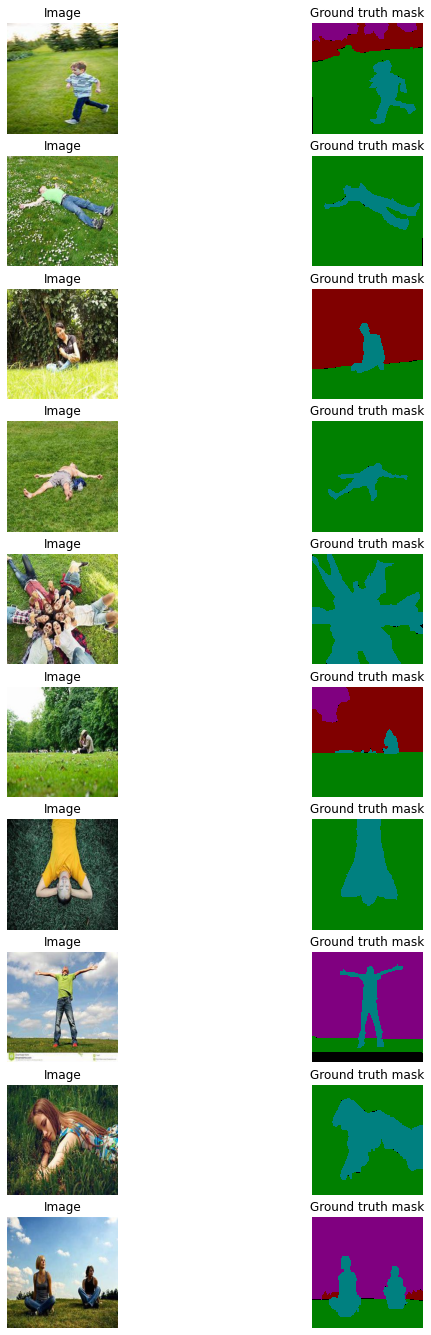

In [202]:
# train_masks = np.array(train_masks)
# print(train_masks.shape)
# train_masks = np.expand_dims(train_masks, axis=3)
# print(train_masks.shape)
images_filenames = list(sorted(os.listdir(images_directory)))
images_filenames = images_filenames[:10]

def display_image_grid(images_filenames, images_directory, masks_directory, predicted_masks=None):
    cols = 3 if predicted_masks else 2
    rows = len(images_filenames)
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 24))
    for i, image_filename in enumerate(images_filenames):
        image = cv2.imread(os.path.join(images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(os.path.join(masks_directory, image_filename.replace(".jpg", ".png")), cv2.IMREAD_UNCHANGED,)
        mask = preprocess_mask(mask)
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")

        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Ground truth mask")

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()

        if predicted_masks:
            predicted_mask = predicted_masks[i]
            ax[i, 2].imshow(predicted_mask, interpolation="nearest")
            ax[i, 2].set_title("Predicted mask")
            ax[i, 2].set_axis_off()
    #plt.tight_layout()
    plt.show()

display_image_grid(images_filenames, images_directory, masks_directory)

In [203]:
# np.unique(train_masks)
# classes = np.unique(train_masks)[9]
classes = len(np.unique(train_masks))
# class = len(classes)
print(classes)


6


In [204]:
from tensorflow.keras.utils import to_categorical
labels_cat = to_categorical(train_masks, num_classes=classes)
print(labels_cat.shape)

(361, 256, 256, 6)


In [205]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_images, labels_cat, test_size = 0.05, random_state = 42)

In [206]:
print(len(X_train), len(X_test))

342 19


In [207]:
# x_val = X_train[-75:]
# y_val = y_train[-75:]
# X_train = X_train[:-75]
# y_train = y_train[:-75]
# print(len(X_train), len(x_val))

In [208]:
# image_number = random.randint(0, len(X_train)-1)
# print(image_number)
# plt.figure(figsize=(12, 6))
# plt.subplot(121)
# plt.imshow(X_train[image_number,:,:,0])
# plt.subplot(122)
# plt.imshow(y_train[image_number,:,:,0])
# plt.show()

In [209]:
!pip install segmentation_models

In [210]:
import segmentation_models as sm

In [211]:
from tensorflow.keras import backend as K
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [212]:
weights = [0.167, 0.167, 0.167, 0.167, 0.167, 0.167]
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  #


IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]


# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
# dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.167, 0.167, 0.167, 0.167, 0.167, 0.167])) 
# focal_loss = sm.losses.CategoricalFocalLoss()
# total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = ['accuracy', jacard_coef]

In [213]:
# def jacard_coef(y_true, y_pred):
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0

In [214]:
import tensorflow as tf
from tensorflow.keras import layers


# Build the model
def unet_model(classes, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    # s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)
    s = inputs

    # Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    # Expansive path
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(classes, (1, 1), activation='softmax')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#     model.summary()
    return model


In [215]:
def get_model():
    return unet_model(classes=classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_95 (Conv2D)             (None, 256, 256, 16  448         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_45 (Dropout)           (None, 256, 256, 16  0           ['conv2d_95[0][0]']              
                                )                                                           

In [216]:
import tensorflow as tf

# X_train_prep = preprocess_input(X_train)
# X_val_prep = preprocess_input(x_val)


modelcheckpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Data/grassModel4.h5', verbose=1, save_best_only=True)
callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'), modelcheckpoint]

In [217]:
history1 = model.fit(X_train, y_train, 
                    batch_size = 4, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(X_test, y_test), 
                    shuffle=False,
                     callbacks=callbacks)

Epoch 1/100
86/86 [==============================] - ETA: 0s - loss: 0.9264 - accuracy: 0.6663 - jacard_coef: 0.3907
Epoch 00001: val_loss improved from inf to 0.52081, saving model to /content/drive/MyDrive/Data/grassModel4.h5
86/86 [==============================] - 16s 163ms/step - loss: 0.9264 - accuracy: 0.6663 - jacard_coef: 0.3907 - val_loss: 0.5208 - val_accuracy: 0.8213 - val_jacard_coef: 0.5629
Epoch 2/100
86/86 [==============================] - ETA: 0s - loss: 0.5809 - accuracy: 0.8188 - jacard_coef: 0.5582
Epoch 00002: val_loss improved from 0.52081 to 0.47869, saving model to /content/drive/MyDrive/Data/grassModel4.h5
86/86 [==============================] - 11s 127ms/step - loss: 0.5809 - accuracy: 0.8188 - jacard_coef: 0.5582 - val_loss: 0.4787 - val_accuracy: 0.8216 - val_jacard_coef: 0.5946
Epoch 3/100
86/86 [==============================] - ETA: 0s - loss: 0.5510 - accuracy: 0.8243 - jacard_coef: 0.5723
Epoch 00003: val_loss did not improve from 0.47869
86/86 [=====

In [218]:
from tensorflow.keras.models import load_model

#model = load_model("/content/drive/MyDrive/Data/grassModel2.h5", custom_objects={'dice_loss_plus2focal_loss': total_loss})

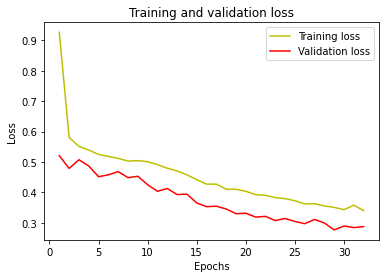

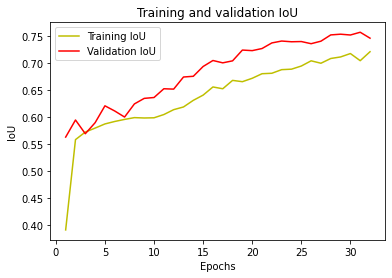

In [219]:
# def plot_metrics(metric_name, title, ylim=5):
#   plt.title(title)
#   plt.ylim(0,ylim)
#   plt.plot(history1.history[metric_name],color='blue',label=metric_name)
#   plt.plot(history1.history['val_' + metric_name],color='green',label='val_' + metric_name)


# plot_metrics("loss", title="Training vs Validation Loss", ylim=1)
history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()


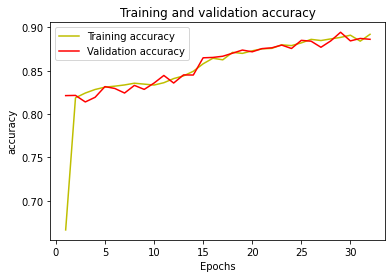

In [220]:
history = history1
loss = history.history['accuracy']
val_loss = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training accuracy')
plt.plot(epochs, val_loss, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# acc = history.history['jacard_coef']
# val_acc = history.history['val_jacard_coef']

# plt.plot(epochs, acc, 'y', label='Training IoU')
# plt.plot(epochs, val_acc, 'r', label='Validation IoU')
# plt.title('Training and validation IoU')
# plt.xlabel('Epochs')
# plt.ylabel('IoU')
# plt.legend()
# plt.show()

In [221]:
train_loss, train_acc, jacc = model.evaluate(X_train, y_train, steps=4)
valid_loss, valid_acc, val_jc = model.evaluate(x_val, y_val, steps=4)
print('Train: %.3f, Test: %.3f' % (train_acc, valid_acc))
print('Train loss: %.3f, Test loss: %.3f' % (train_loss, valid_loss))
print('Train Jaccard: %.3f, Test Jaccard: %.3f' % (jacc, val_jc))

4/4 [==============================] - 1s 158ms/step - loss: 0.2954 - accuracy: 0.9031 - jacard_coef: 0.7236
Train: 0.897, Test: 0.903
Train loss: 0.321, Test loss: 0.295
Train Jaccard: 0.726, Test Jaccard: 0.724


In [222]:
from tensorflow.keras.models import load_model

# model = load_model('/content/drive/MyDrive/Data/grassModel.h5')

In [223]:
#IOU
y_pred=model.predict(x_val)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_val, axis=3)


In [224]:
#Using built in keras function for IoU
from keras.metrics import MeanIoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.32551992


In [233]:
import random
test_img_number = random.randint(0, len(X_test)-1)
print(test_img_number)
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


3


In [226]:


# predicted_imgs = []
# for i in range(len(X_test)):
#   test_img = X_test[i]
#   ground_truth = y_test_argmax[i]
#   test_img_input =np.expand_dims(test_img, 0)
#   prediction = (model.predict(test_img_input))
#   predicted_imgs.append(np.argmax(prediction, axis=3)[0,:,:])


# display_image_grid(test_images_filenames, images_directory, masks_directory, predicted_masks=predicted_imgs)

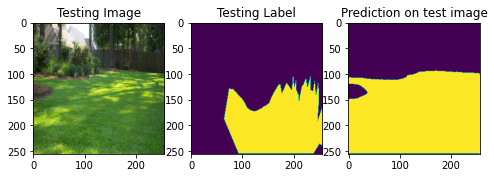

In [234]:

# plt.figure(figsize=(12, 8))
plt.figure(figsize=(8, 6))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

In [228]:
predictions = model.predict(X_test)
  

In [229]:
bb = []
for i in predictions:
  bb.append(i)

TypeError: ignored

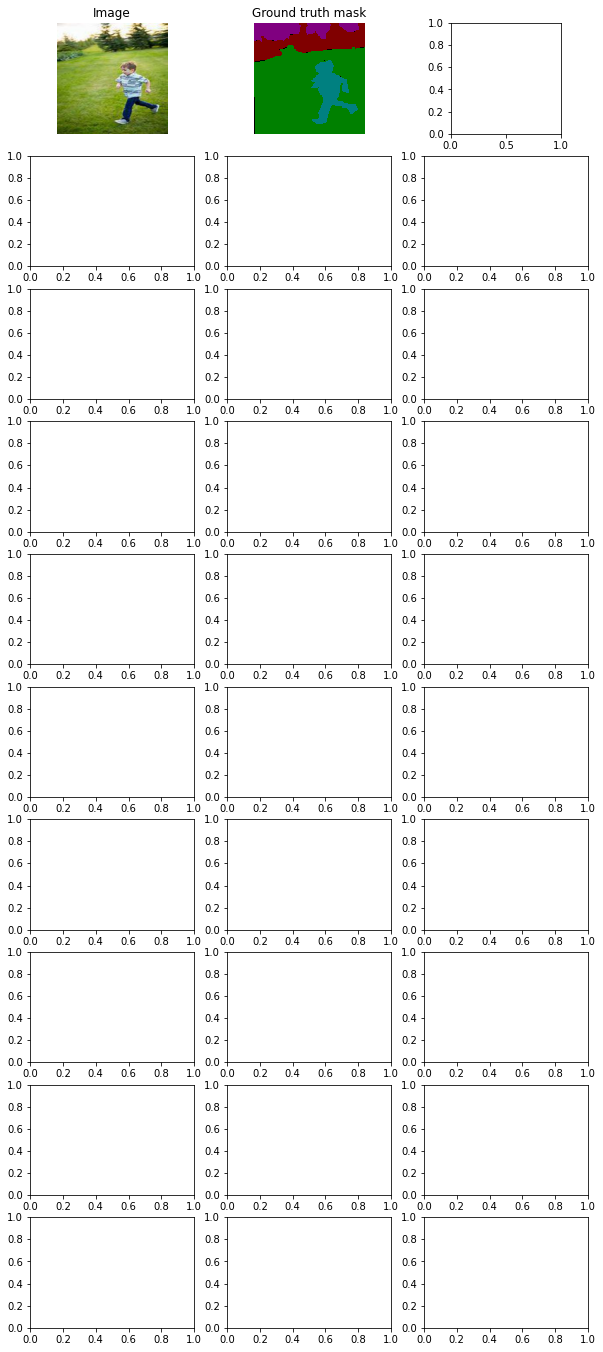

In [230]:
display_image_grid(images_filenames, images_directory, masks_directory, predicted_masks=bb)